In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, log_loss, confusion_matrix
from sklearn.externals import joblib
import warnings
import itertools
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
#read raw data
restaurant = pd.read_csv("DOHMH_New_York_City_Restaurant_Inspection_Results.csv", dtype = {'ZIPCODE':str, 'PHONE':str}, parse_dates = ['INSPECTION DATE', 'GRADE DATE', 'RECORD DATE'])


In [3]:
restaurant = restaurant.drop(['ACTION', 'VIOLATION CODE', 'VIOLATION DESCRIPTION', 'CRITICAL FLAG'], axis=1)

In [4]:
restaurant = restaurant.drop(['INSPECTION TYPE'], axis=1)

In [32]:
tmp = restaurant[restaurant['SCORE'].isnull()]

In [33]:
tmp[tmp['GRADE'].notnull()]

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,SCORE,GRADE,GRADE DATE,RECORD DATE
26628,50065304,CHURCH AVENUE PIZZA,BROOKLYN,1916B,CHURCH AVE,11226,7184626060,Pizza,2017-12-11,NaN,Not Yet Graded,NaT,2018-02-02
126947,50059949,FLIK @ HOLY NAME PROVINCE,MANHATTAN,129,W 31ST ST,10001,6464730265,Other,2017-03-06,NaN,Not Yet Graded,NaT,2018-02-02
184576,41648221,YEMEN ALSAED CAFE,BROOKLYN,7130,5 AVENUE,11209,7187453000,Middle Eastern,2016-03-09,NaN,A,2016-03-09,2018-02-02
211791,41648221,YEMEN ALSAED CAFE,BROOKLYN,7130,5 AVENUE,11209,7187453000,Middle Eastern,2016-03-09,NaN,A,2016-03-09,2018-02-02
364831,50051917,KENNEDY FRIED CHICKEN & PIZZA,BRONX,2558,GRAND CONCOURSE,10458,7187330300,Chicken,1900-01-01,NaN,A,NaT,2018-02-02


In [6]:
restaurant['target'] = restaurant['SCORE'].map(lambda x: 1 if x > 13 else 0)

In [7]:
data = restaurant[restaurant['SCORE'].notnull()]

In [8]:
datag = data.groupby(['CAMIS'], as_index = False)[['target']].max()

In [9]:
data_dup = data.drop(['target', 'INSPECTION DATE', 'SCORE', 'GRADE', 'GRADE DATE', 'RECORD DATE'], axis=1)

In [10]:
data_dup2 = data_dup.drop_duplicates(['CAMIS']).reset_index(drop=True)

In [11]:
data_merge = data_dup2.merge(datag, on='CAMIS')

In [12]:
data_merge.groupby(['target']).count()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION
target,,,,,,,,
0,7911,7911,7911,7903,7911,7911,7911,7911
1,17653,17653,17653,17648,17653,17653,17652,17653


In [36]:
data_lat_lng = pd.read_csv("data_lat_lng.csv", dtype = {'ZIPCODE':str, 'PHONE':str})

In [46]:
data_lat_lng = data_lat_lng.dropna(axis=0, subset=['latitude', 'longitude'])

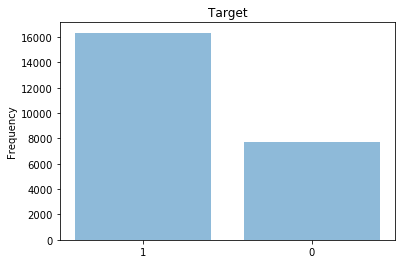

In [69]:
#generate binary class label:either A(0) or not(rare, 1)
y_tables = data_lat_lng['target'].value_counts()
y_pos = np.arange(len(y_tables.values))
plt.bar(y_pos, y_tables.values, align='center', alpha=0.5)
plt.xticks(y_pos, list( y_tables.index))
plt.ylabel('Frequency')
plt.title('Target')
plt.show()

In [47]:
boro = pd.get_dummies(data_lat_lng['BORO'], drop_first = True)

zipcode = pd.get_dummies(data_lat_lng['ZIPCODE'], drop_first = True)

cusine = pd.get_dummies(data_lat_lng['CUISINE DESCRIPTION'], drop_first = True)

model_data = pd.concat([data_lat_lng['target'], data_lat_lng['latitude'], data_lat_lng['longitude'], boro, zipcode, cusine], axis = 1)


#partition data 70% for modeling, 30% for holdout
Xtrain, Xhold, ytrain, yhold = train_test_split(model_data.drop(['target'], axis = 1), model_data['target'], test_size = 0.3, random_state = 42)

In [49]:
#using weighted regularized logistic regression
lr_estimator = LogisticRegression()
param_test = {'C':[0.01, 1, 100, 10000, 10000000], 'class_weight':[{1: 6}, {1: 5}, {1: 4}, {1: 3}, {1: 2}, {1: 1}]}
glr = GridSearchCV(lr_estimator, param_grid = param_test, cv = 5, scoring = 'f1')
glr = glr.fit(Xtrain, ytrain)
blr = glr.best_estimator_.fit(Xtrain,ytrain)

print (glr.best_params_)
lr_score = glr.best_score_
print ('f1 score: ', lr_score)

#joblib.dump(blr, 'ori_lr.pkl')

{'C': 1, 'class_weight': {1: 2}}
f1 score:  0.813605905302


In [53]:
#using weighted regularized logistic regression
lr_estimator = LogisticRegression()
param_test = {'C':[0.1, 1, 100, 10000, 10000000], 'class_weight':[{1: 6}, {1: 5}, {1: 4}, {1: 3}, {1: 2}, {1: 1}]}
glr = GridSearchCV(lr_estimator, param_grid = param_test, cv = 5, scoring = 'roc_auc')
glr = glr.fit(Xtrain, ytrain)
blr = glr.best_estimator_.fit(Xtrain,ytrain)

print (glr.best_params_)
lr_score = glr.best_score_
print ('roc_auc score: ', lr_score)

#joblib.dump(blr, 'ori_lr.pkl')

{'C': 0.1, 'class_weight': {1: 5}}
roc_auc score:  0.630607046185


In [55]:
#using weighted regularized logistic regression
lr_estimator = LogisticRegression()
param_test = {'C':[0.03, 0.1, 0.3], 'class_weight':[{1: 5.5}, {1: 5}, {1: 4.5}]}
glr = GridSearchCV(lr_estimator, param_grid = param_test, cv = 5, scoring = 'roc_auc')
glr = glr.fit(Xtrain, ytrain)
blr = glr.best_estimator_.fit(Xtrain,ytrain)

print (glr.best_params_)
lr_score = glr.best_score_
print ('roc_auc score: ', lr_score)

#joblib.dump(blr, 'ori_lr.pkl')

{'C': 0.03, 'class_weight': {1: 5}}
roc_auc score:  0.630697511972


In [59]:
#using weighted regularized logistic regression
lr_estimator = LogisticRegression()
param_test = {'C':[0.003, 0.01, 0.03], 'class_weight':[{1: 5.5}, {1: 5}, {1: 4.5}]}
glr = GridSearchCV(lr_estimator, param_grid = param_test, cv = 5, scoring = 'roc_auc')
glr = glr.fit(Xtrain, ytrain)
blr = glr.best_estimator_.fit(Xtrain,ytrain)

print (glr.best_params_)
lr_score = glr.best_score_
print ('roc_auc score: ', lr_score)

joblib.dump(blr, 'ori_lr.pkl')

{'C': 0.03, 'class_weight': {1: 5}}
roc_auc score:  0.630697511972


['ori_lr.pkl']

In [61]:
#using weighted regularized logistic regression
lr_estimator = LogisticRegression()
param_test = {'C':[0.03], 'class_weight':[{1: 5}]}
glr = GridSearchCV(lr_estimator, param_grid = param_test, cv = 5, scoring = 'f1')
glr = glr.fit(Xtrain, ytrain)
blr = glr.best_estimator_.fit(Xtrain,ytrain)

print (glr.best_params_)
lr_score = glr.best_score_
print ('f1: ', lr_score)

joblib.dump(blr, 'ori_lr.pkl')

{'C': 0.03, 'class_weight': {1: 5}}
f1:  0.811425346742


['ori_lr.pkl']

In [50]:
#using weighted random forest
rf_estimator = RandomForestClassifier(max_leaf_nodes = 200, min_samples_leaf = 10, min_samples_split = 2, n_estimators = 500, random_state = 1234, n_jobs = -1)
param_test = {'max_features': [0.2, 0.3, 0.4], 'min_samples_leaf': [10, 15, 20]}
grf = GridSearchCV(rf_estimator, param_grid = param_test, cv = 5, scoring = 'roc_auc')
grf = grf.fit(Xtrain, ytrain)
brf = grf.best_estimator_.fit(Xtrain,ytrain)

print (grf.best_params_)
rf_score = grf.best_score_
print ('roc_auc score: ', rf_score)

#joblib.dump(brf, 'ori_rf.pkl')

{'max_features': 0.3, 'min_samples_leaf': 10}
roc_auc score:  0.633025315983


In [57]:
#using weighted random forest
rf_estimator = RandomForestClassifier(max_leaf_nodes = 200, min_samples_leaf = 10, min_samples_split = 2, n_estimators = 500, random_state = 1234, n_jobs = -1)
param_test = {'max_features': [0.2, 0.3, 0.4], 'n_estimators': [100, 200, 300]}
grf = GridSearchCV(rf_estimator, param_grid = param_test, cv = 5, scoring = 'roc_auc')
grf = grf.fit(Xtrain, ytrain)
brf = grf.best_estimator_.fit(Xtrain,ytrain)

print (grf.best_params_)
rf_score = grf.best_score_
print ('roc_auc score: ', rf_score)

#joblib.dump(brf, 'ori_rf.pkl')

{'n_estimators': 300, 'max_features': 0.3}
roc_auc score:  0.632996698351


In [58]:
#using weighted random forest
rf_estimator = RandomForestClassifier(max_leaf_nodes = 200, min_samples_leaf = 10, min_samples_split = 2, n_estimators = 500, max_features = 0.3, random_state = 1234, n_jobs = -1)
param_test = {'min_samples_leaf': [5, 10, 15], 'n_estimators': [300, 400, 500]}
grf = GridSearchCV(rf_estimator, param_grid = param_test, cv = 5, scoring = 'roc_auc')
grf = grf.fit(Xtrain, ytrain)
brf = grf.best_estimator_.fit(Xtrain,ytrain)

print (grf.best_params_)
rf_score = grf.best_score_
print ('roc_auc score: ', rf_score)

#joblib.dump(brf, 'ori_rf.pkl')

{'n_estimators': 500, 'min_samples_leaf': 10}
roc_auc score:  0.633025315983


In [64]:
#using weighted random forest
rf_estimator = RandomForestClassifier(max_leaf_nodes = 200, min_samples_leaf = 10, min_samples_split = 2, n_estimators = 500, max_features = 0.3, random_state = 1234, n_jobs = -1)
param_test = {'min_samples_leaf': [10], 'n_estimators': [300]}
grf = GridSearchCV(rf_estimator, param_grid = param_test, cv = 5, scoring = 'roc_auc')
grf = grf.fit(Xtrain, ytrain)
brf = grf.best_estimator_.fit(Xtrain,ytrain)

print (grf.best_params_)
rf_score = grf.best_score_
print ('roc_auc score: ', rf_score)

joblib.dump(brf, 'ori_rf.pkl')

{'n_estimators': 300, 'min_samples_leaf': 10}
roc_auc score:  0.632996698351


['ori_rf.pkl']

Feature ranking:
1 latitude
2 longitude
3 Other
4 CafÃ©/Coffee/Tea
5 Sandwiches
6 Donuts
7 American
8 10121
9 Juice, Smoothies, Fruit Salads
10 Ice Cream, Gelato, Yogurt, Ices
11 11368
12 Sandwiches/Salads/Mixed Buffet
13 Latin (Cuban, Dominican, Puerto Rican, South & Central American)
14 BROOKLYN
15 Hamburgers
16 MANHATTAN
17 Chinese
18 QUEENS
19 11217
20 Salads


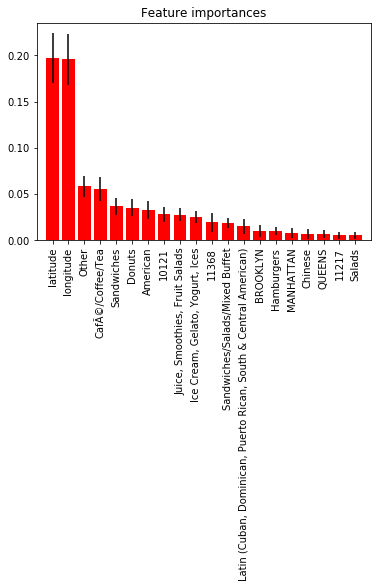

In [70]:
def plotFeatureImportance(tree_obj, n, features):
    importances = tree_obj.feature_importances_
    std = np.std([tree.feature_importances_ for tree in tree_obj.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(n):
        print((f + 1), features[indices[f]])

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(n), importances[indices[:n]], color="r", yerr=std[indices[:n]], align="center")
    plt.xticks(range(n), features[indices[:n]], rotation=90)
    plt.xlim([-1,n])
    plt.show()

plotFeatureImportance(brf, 20, np.array(Xtrain.columns.values))

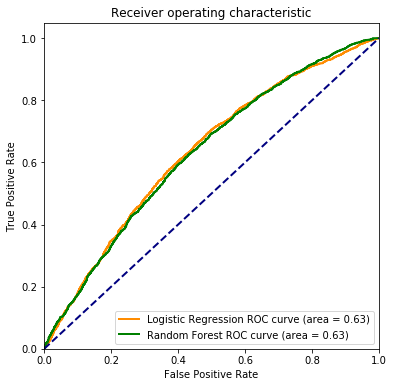

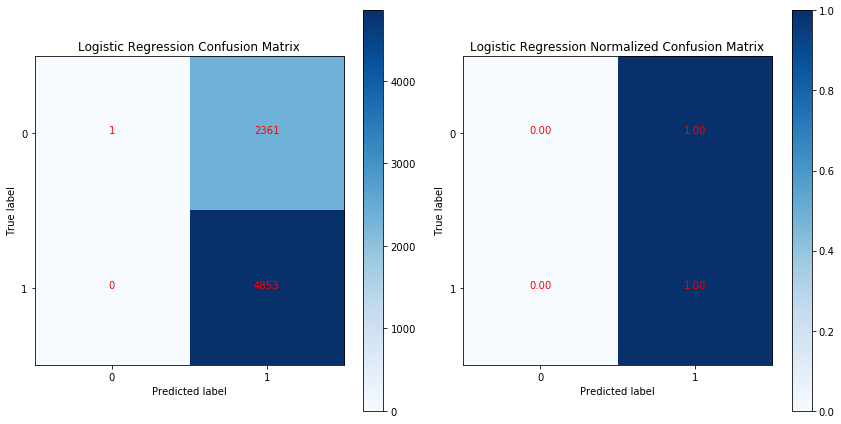

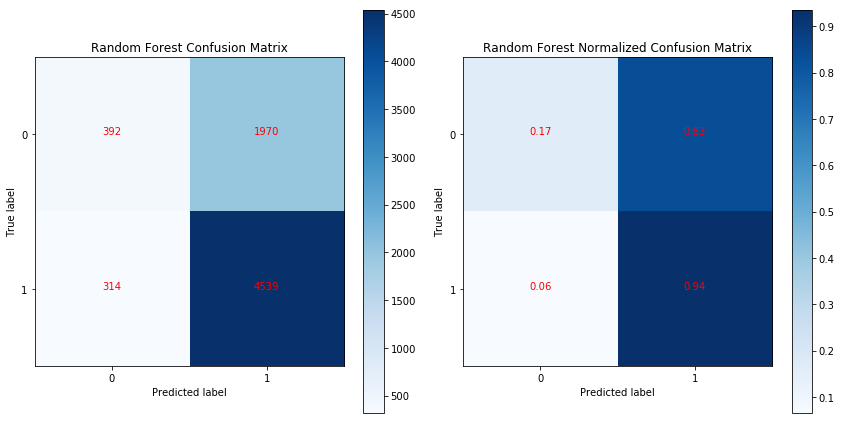

In [75]:
#model performance util functions
def plotLabel(ax):
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('Receiver operating characteristic')
        ax.legend(loc="lower right")



def make_com_roc_curve(g_ypred_pro, yh, g_model):        
        fpr = []
        tpr = []
        roc_auc = []
        n = len(g_ypred_pro)
        for i in range(n):
            ypred_pro1 = g_ypred_pro[i]
            fpr1, tpr1, _ = roc_curve(yh, ypred_pro1[:, 1])
            roc_auc1 = auc(fpr1, tpr1)
            fpr.append(fpr1)
            tpr.append(tpr1)
            roc_auc.append(roc_auc1)
    
        #plt.figure()
        fig, ax = plt.subplots(figsize=(6,6))
        lw = 2
        color = ['darkorange', 'green']
        for i in range(n):
            
            ax.plot(fpr[i], tpr[i], color=color[i], lw=lw, label= g_model[i] + ' ROC curve (area = %0.2f)' % roc_auc[i])
        
        ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plotLabel(ax)
    
        plt.show()

def plotcm(fig, ax, cm, classes, model = '', normalize = False, cmap=plt.cm.Blues):
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            title = model + " Normalized Confusion Matrix"
        else:
            title = model + ' Confusion Matrix'

        img = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.set_title(title)
        fig.colorbar(img, ax=ax)
        #tick_marks = np.arange(len(classes))
        ax.set_xticks(classes) #, rotation=45)
        ax.set_yticks(classes)
        #ax.set_xticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            #color="red" if cm[i, j] > thresh else "black")
            color="red")
        
        ax.set_ylabel('True label')
        ax.set_xlabel('Predicted label')
        
    
def make_confusion_matrix(ypred, yh, model = ""):
        cnf_matrix = confusion_matrix(yh, ypred)
        
        np.set_printoptions(precision=2)
        classes = list(np.unique(yh))
        
        
        #plt.figure()
        fig, (ax1, ax2)= plt.subplots(ncols=2, figsize=(12, 6))
        plotcm(fig, ax1, cnf_matrix, classes, model, False)
        #plt.figure()
        plotcm(fig, ax2, cnf_matrix, classes, model, True)
        
        
        plt.tight_layout()
        plt.show()

ypred_pro1 = blr.predict_proba(Xhold)
ypred_pro2 = brf.predict_proba(Xhold)
ypred1 = blr.predict(Xhold)
ypred2 = brf.predict(Xhold)
model1 = 'Logistic Regression'
model2 = 'Random Forest'
make_com_roc_curve([ypred_pro1, ypred_pro2], yhold, [model1, model2]) 
make_confusion_matrix(ypred1, yhold, model = model1)
make_confusion_matrix(ypred2, yhold, model = model2)